<a href="https://colab.research.google.com/github/Shruti-codes/SHALA2020/blob/master/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# import pandas as pd
# from google.colab import drive
# drive.mount('/content/drive')
# df = pd.read_csv("drive/My Drive/uci-news-aggregator.csv", usecols = ['TITLE', 'CATEGORY'])

!gdown --id 1fZL9PDPhiEiGp5h_2LNWZ4wAx8tberfT

Downloading...
From: https://drive.google.com/uc?id=1fZL9PDPhiEiGp5h_2LNWZ4wAx8tberfT
To: /content/uci-news-aggregator.csv
103MB [00:00, 111MB/s]  


In [3]:
import csv
import tensorflow as tf
import numpy as np
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# print(tf.__version__)



articles = []
labels = []

with open('uci-news-aggregator.csv') as file:
	reader = csv.reader(file, delimiter = ",")
	next(reader)
	for row in reader:
		labels.append(row[4])
		article = row[1]
		for word in stopwords:
			token = ' '+word+' '
			article = article.replace(token,' ')
			article = article.replace('  ',' ')
		articles.append(article)

In [26]:
print(len(labels))
print(len(articles))

#shuffle data (optional)

#converting to tokens
tokenizer = Tokenizer(num_words = 7000, oov_token = 'OOV', lower=True)
tokenizer.fit_on_texts(articles)
sequences_a = np.array(tokenizer.texts_to_sequences(articles))
word_ind = tokenizer.word_index

print(dict(list(word_ind.items())[0:20]))
print(sequences_a[8])
print("Found %s unique tokens " %len(word_ind))

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
training_label_seq = np.array(label_tokenizer.texts_to_sequences(labels))

422419
422419
{'OOV': 1, 'the': 2, 'new': 3, 'us': 4, 'to': 5, 'in': 6, 'google': 7, 'a': 8, 'is': 9, '2014': 10, 'video': 11, 'for': 12, 'of': 13, 'apple': 14, 'says': 15, 'with': 16, '2': 17, 'first': 18, 'on': 19, '1': 20}
[4, 222, 160, 249, 216, 211, 1062, 200, 701, 6725, 1]
Found 75285 unique tokens 


In [34]:
from tensorflow.keras.utils import to_categorical
X = pad_sequences(sequences_a, maxlen=50, padding='post', truncating='post')

X_train, X_test, y_train, y_test = train_test_split(X, training_label_seq, test_size = 0.25, random_state = 43 )

y_train = to_categorical(y_train, 5)
y_test = to_categorical(y_test, 5)
print(X_train.shape)



(316814, 50)


In [35]:
#64 = Embedding dimension, 7000 = Most common words (hyperparam)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(7000, 64),
		# tf.keras.layers.SpatialDropout1D(0.7),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.7)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(5, activation='softmax')
])
model.summary()

print(set(labels))

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 64)          448000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               66048     
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 325       
Total params: 522,629
Trainable params: 522,629
Non-trainable params: 0
_________________________________________________________________
{'e', 'b', 't', 'm'}


Epoch 1/10
1981/1981 [==============================] - 271s 137ms/step - loss: 0.3582 - accuracy: 0.8658 - val_loss: 0.2136 - val_accuracy: 0.9245
Epoch 2/10
1981/1981 [==============================] - 271s 137ms/step - loss: 0.2279 - accuracy: 0.9187 - val_loss: 0.2092 - val_accuracy: 0.9261
Epoch 3/10
1981/1981 [==============================] - 271s 137ms/step - loss: 0.2149 - accuracy: 0.9225 - val_loss: 0.2027 - val_accuracy: 0.9273
Epoch 4/10
1981/1981 [==============================] - 271s 137ms/step - loss: 0.2071 - accuracy: 0.9254 - val_loss: 0.1983 - val_accuracy: 0.9281
Epoch 5/10
1981/1981 [==============================] - 269s 136ms/step - loss: 0.2020 - accuracy: 0.9265 - val_loss: 0.1972 - val_accuracy: 0.9294
Epoch 6/10
1981/1981 [==============================] - 275s 139ms/step - loss: 0.1958 - accuracy: 0.9293 - val_loss: 0.1967 - val_accuracy: 0.9294
Epoch 7/10
1981/1981 [==============================] - 272s 137ms/step - loss: 0.1921 - accuracy: 0.9305 - val_

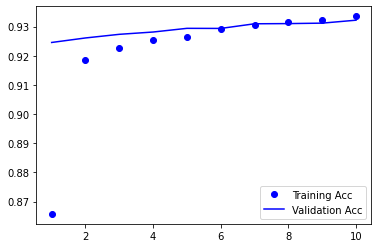

<Figure size 432x288 with 0 Axes>

In [36]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
num_epochs = 10
history = model.fit(X_train, y_train, epochs= num_epochs, validation_split= 0.2 , batch_size = 128, verbose = 1)


acc = history.history['accuracy']
acc_val = history.history['val_accuracy']
loss = history.history['loss']
loss_val = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'bo', label = 'Training Acc')
plt.plot(epochs, acc_val, 'b', label = 'Validation Acc')
plt.legend()
plt.figure()

(loss, accuracy) = model.evaluate(X_test, y_test, batch_size=128)
print(accuracy*100)

model.save_weights("uci-news-aggregator.hdf5", overwrite = True)

In [37]:
articles[:10]

['Fed official says weak data caused weather, slow taper',
 "Fed's Charles Plosser sees high bar change pace tapering",
 'US open: Stocks fall Fed official hints accelerated tapering',
 "Fed risks falling 'behind curve', Charles Plosser says",
 "Fed's Plosser: Nasty Weather Has Curbed Job Growth",
 'Plosser: Fed May Have Accelerate Tapering Pace',
 "Fed's Plosser: Taper pace may slow",
 "Fed's Plosser expects US unemployment fall 6.2% end 2014",
 'US jobs growth last month hit weather:Fed President Charles Plosser',
 'ECB unlikely end sterilisation SMP purchases - traders']